# New version with CNN

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import keras
from keras.layers import MaxPooling2D, UpSampling2D
from keras.layers import Conv2D, Input, Dense
from keras.models import Model
from keras.models import Sequential
import pandas as pd
import librosa
import librosa.display
import matplotlib.pyplot as plt
import cv2
from sklearn.cluster import KMeans

# https://medium.com/@iampatricolee18/autoencoder-k-means-clustering-epl-players-by-their-career-statistics-f38e2ea6e375
# https://blog.keras.io/building-autoencoders-in-keras.html
# https://medium.com/cubicalchrome/autoencoder-in-spectrogram-1b789f538adb
# https://towardsdatascience.com/no-kernels-filters-are-not-the-same-b230ec192ac9
# https://towardsdatascience.com/convolutional-autoencoders-for-image-noise-reduction-32fce9fc1763

In [2]:
musicFilePath = "./music/"
specFilePath = "./spectrogram/"
songFile = musicFilePath + "songs.txt"
specLengthPix = 300
specWidthPix = 300
specOffset = 15
specDuration = 120

In [3]:
# Generates spectrograms for list of songs and stores them as files
# Parameters: 
# li: list of song audio filenames
# off: offset of sound snippet to capture in spectrogram
# dur: duration of sound snippet to capture in spectrogram
# mfp: path to folder with song audio files
# sfp: path to store spectrogram files
def genSpec(li, off, dur, mfp, sfp):
    for i in range(0,len(li)):
        fileName = li[i]
        s, s_rate = librosa.load(mfp + fileName, sr=None, offset=off, duration=dur)
        
        ## Short-time Fourier transform (STFT)
        ## Returns complex-valued matrix of short-term Fourier transform coefficients
        spec = librosa.stft(s)
        
        ## Graphs time vs. frequency
        ## Shows amplitude using colors (higher amplitude = brighter color)
        # librosa.display.specshow(spec)
        
        ## Mel Spectrogram
        ## Separate a complex-valued spectrogram D into its magnitude (S) and phase (P) components, so that D = S * P
        spec_mag, _ = librosa.magphase(spec)
        spec_mel = librosa.feature.melspectrogram(S=spec_mag, sr=s_rate)
        # librosa.display.specshow(spec_mel)
        # print(spec_mag)
        
        ## Final Mel Spectrogram (uses the decibel scale)
        ## Converts an amplitude spectrogram to dB-scaled spectrogram
        spec_mel_amp = librosa.amplitude_to_db(spec_mel)
        librosa.display.specshow(spec_mel_amp,sr=s_rate, x_axis='time', y_axis='mel')
        plt.colorbar(format='%+2.0f dB')
        plt.savefig(sfp + fileName + "_spec.png", bbox_inches='tight')
        plt.clf()

In [4]:
songs = pd.read_table(songFile, delimiter='\t')
print(songs)
genSpec(songs["File"], specOffset, specDuration, musicFilePath, specFilePath)

           File           Artist                   Title
0      id_b.mp3  Imagine Dragons                Believer
1      id_n.mp3  Imagine Dragons                 Natural
2    s_eott.mp3         Survivor        Eye of the Tiger
3    be_eiw.mp3    Billie Eilish     Everything I Wanted
4   lc_atkd.mp3    Leonard Cohen  A Thousand Kisses Deep
5      jc_h.mp3      Johnny Cash                    Hurt
6    ec_tih.mp3     Eric Clapton         Tears in Heaven
7     s_fog.mp3            Sting          Fields of Gold
8    g_homh.mp3          Genesis        Hold on My Heart
9      dj_s.mp3    Damien Jurado                  Sheets
10     es_s.mp3       Ed Sheeran                 Shivers
11    m_lib.mp3          Madonna          La Isla Bonita
12     e_hc.mp3           Eagles        Hotel California
13   tai_dm.mp3      Tones and I            Dance Monkey
14    bg_sa.mp3         Bee Gees           Stayin' Alive


/Users/ashwini/miniforge3/lib/python3.9/site-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
/Users/ashwini/miniforge3/lib/python3.9/site-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
/Users/ashwini/miniforge3/lib/python3.9/site-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
/Users/ashwini/miniforge3/lib/python3.9/site-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
/Users/ashwini/miniforge3/lib/python3.9/site-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Try

<Figure size 432x288 with 0 Axes>

In [5]:
# Standardizes spectrograms to feed to autoencoder by converting them to gray-scale,
# scaling pixel values from 0-255 to 0-1, and resizing images
# Parameters:
# li: list of song audio filenames
# sfp: path to where spectrogram files are stored
# lPix: pixel length to rescale images to
# wPix: pixel width to rescale images to
def standSpec(li, sfp, lPix, wPix):
    trainSet = []
    plt.gray()
    for i in range(0, len(li)):
        fileName = li[i]
        # Converts image to grayscale
        sp = cv2.imread(sfp + fileName + "_spec.png", 0)
        # print(sp[50][100])
        
        # Scales pixel values to 0-1
        sp = sp.astype('float32')/255.0
        # print(sp[50][100])
        # print(sp)
        
        # Resizes image
        sp = cv2.resize(sp,(lPix,wPix))
        plt.imshow(sp)
        plt.savefig(sfp + fileName + "_spec_gscale.png",bbox_inches='tight')
        plt.clf()
        # cv2.imwrite(sfp + fileName + "_spec_gscale.png", sp)
        trainSet.append(sp)

    # trainSet = np.array(trainSet)
    trainSet = np.reshape(trainSet, (len(trainSet),lPix,wPix,1))
    return trainSet

In [6]:
train = standSpec(songs["File"], specFilePath, specLengthPix, specWidthPix)

<Figure size 432x288 with 0 Axes>

In [7]:
train.shape

(15, 300, 300, 1)

In [29]:
# inputShape = tuple (28,28,1)
# layerSeq = list of layers = [conv, maxpooling2D, conv]
# numFilters = list of number of filters per layer [3,2,2]
# filterSize = list of dimension of the square filter per layer [3,4,4]
# means 3x3 filter on first layer, 4x4 on second layer, ...
# pad = padding for each layer ["valid", "same", "valid"]
def genModelCNN(inputShape, layerSeq, numFilters, kernelSize, pad, act):
    autoencoder = Sequential()
    
    for l in range(0, len(layerSeq)):
        if (layerSeq[l] == "Input"):
            autoencoder.add(Input(shape = inputShape))
        elif (layerSeq[l] == "C2D"):
            autoencoder.add(Conv2D(numFilters[l], (kernelSize[l], kernelSize[l]), 
                                   activation=act[l], padding=pad[l]))
        elif (layerSeq[l] == "MP2D"):
            autoencoder.add(MaxPooling2D((kernelSize[l], kernelSize[l]), padding=pad[l]))
        elif (layerSeq[l] == "US2D"):
            autoencoder.add(UpSampling2D((kernelSize[l], kernelSize[l])))
        else:
            print("Could not interpret layer")
    
    autoencoder.compile(optimizer = "adam", loss = "binary_crossentropy")
    # encoder = Model(inputs=autoencoder.input, outputs=autoencoder.layers[len(layerSeq)//2 - 1].output)
    # latShape = autoencoder.layers[len(layerSeq)//2-1].output_shape
    # dInput = Input(shape=latShape)
    # decoder = Model(inputs=Input(shape=latShape), outputs=autoencoder.layers[len(layerSeq)-2](dInput).output)
    latentShape = autoencoder.layers[(len(layerSeq)-1)//2].output_shape
    latentShape = latentShape[1:]
    print(latentShape)
    
    encoder = Sequential()
    encoder.add(Input(shape = inputShape))
    for i in range(0, (len(layerSeq)-1)//2+1):
        encoder.add(autoencoder.layers[i])
    
    decoder = Sequential()
    decoder.add(Input(shape = latentShape))
    for i in range((len(layerSeq)-1)//2+1,len(layerSeq)-1):
        decoder.add(autoencoder.layers[i])
        
    return autoencoder, encoder, decoder, latentShape;

In [35]:
inputShape = (specLengthPix,specWidthPix,1)
layerSeq = ["Input", "C2D", "MP2D", "C2D", "MP2D", "C2D", "MP2D", "C2D", "MP2D" , "C2D" , "US2D", 
            "C2D", "US2D", "C2D","US2D", "C2D", "US2D", "C2D"]
# numFilters = [-1,16,-1,8,-1,8,-1,8,-1,8,-1,16,-1,1]
numFilters = [-1,16,-1,8,-1,8,-1,8,-1,1,-1,8,-1,8,-1,8,-1,1]
kernelSize = [-1,3,2,3,2,3,2,3,2,3,2,3,2,3,2,3,2,3]
pad = ["-1", "same", "same", "same", "same", "same", "same", "same", "same", 
       "same", "-1", "same", "-1", "same", "-1", "valid", "-1", "same"]
act = ["-1", "relu", "-1", "relu", "-1", "relu", "-1", "relu", "-1", 
       "relu", "-1", "relu", "-1", "relu", "-1", "relu", "-1", "sigmoid"]

In [36]:
# Creates the autoencoder, encoder, and decoder based on parameters
ae,e,d,latentShape = genModelCNN(inputShape, layerSeq, numFilters, kernelSize, pad, act)

(19, 19, 1)


In [37]:
ae.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_24 (Conv2D)          (None, 300, 300, 16)      160       
                                                                 
 max_pooling2d_11 (MaxPoolin  (None, 150, 150, 16)     0         
 g2D)                                                            
                                                                 
 conv2d_25 (Conv2D)          (None, 150, 150, 8)       1160      
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 75, 75, 8)        0         
 g2D)                                                            
                                                                 
 conv2d_26 (Conv2D)          (None, 75, 75, 8)         584       
                                                                 
 max_pooling2d_13 (MaxPoolin  (None, 38, 38, 8)       

In [38]:
e.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_24 (Conv2D)          (None, 300, 300, 16)      160       
                                                                 
 max_pooling2d_11 (MaxPoolin  (None, 150, 150, 16)     0         
 g2D)                                                            
                                                                 
 conv2d_25 (Conv2D)          (None, 150, 150, 8)       1160      
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 75, 75, 8)        0         
 g2D)                                                            
                                                                 
 conv2d_26 (Conv2D)          (None, 75, 75, 8)         584       
                                                                 
 max_pooling2d_13 (MaxPoolin  (None, 38, 38, 8)       

In [39]:
d.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 up_sampling2d_11 (UpSamplin  (None, 38, 38, 1)        0         
 g2D)                                                            
                                                                 
 conv2d_29 (Conv2D)          (None, 38, 38, 8)         80        
                                                                 
 up_sampling2d_12 (UpSamplin  (None, 76, 76, 8)        0         
 g2D)                                                            
                                                                 
 conv2d_30 (Conv2D)          (None, 76, 76, 8)         584       
                                                                 
 up_sampling2d_13 (UpSamplin  (None, 152, 152, 8)      0         
 g2D)                                                            
                                                      

In [40]:
ae.fit(train, train, batch_size=32, epochs=50)

Epoch 1/50
1/1 [==============================] - 1s 614ms/step - loss: 0.6927
Epoch 2/50
1/1 [==============================] - 0s 257ms/step - loss: 0.6907
Epoch 3/50
1/1 [==============================] - 0s 257ms/step - loss: 0.6882
Epoch 4/50
1/1 [==============================] - 0s 253ms/step - loss: 0.6850
Epoch 5/50
1/1 [==============================] - 0s 252ms/step - loss: 0.6810
Epoch 6/50
1/1 [==============================] - 0s 255ms/step - loss: 0.6759
Epoch 7/50
1/1 [==============================] - 0s 252ms/step - loss: 0.6695
Epoch 8/50
1/1 [==============================] - 0s 255ms/step - loss: 0.6615
Epoch 9/50
1/1 [==============================] - 0s 268ms/step - loss: 0.6518
Epoch 10/50
1/1 [==============================] - 0s 260ms/step - loss: 0.6400
Epoch 11/50
1/1 [==============================] - 0s 253ms/step - loss: 0.6261
Epoch 12/50
1/1 [==============================] - 0s 257ms/step - loss: 0.6101
Epoch 13/50
1/1 [==============================] 

In [41]:
# Images produced by the autoencoder (should be nearly identical to the input images)
aeImgs = ae.predict(train)

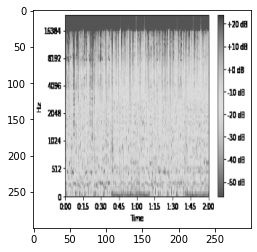

In [42]:
# Input spectrogram
imgIndex = 0
plt.imshow(train[imgIndex].reshape(specLengthPix,specWidthPix))

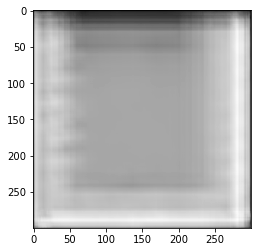

In [43]:
# Image generated by autoencoder
plt.imshow(aeImgs[imgIndex].reshape(specLengthPix,specWidthPix))

(15, 19, 19, 1)

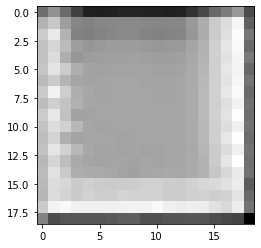

In [44]:
eImgs = e.predict(train)
# At the latent space layer
plt.imshow(eImgs[imgIndex])
eImgs.shape

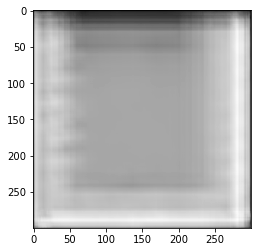

In [45]:
dImgs = d.predict(eImgs)
# Puts the encoded images through the decoder to get what is produced by the autoencoder
plt.imshow(dImgs[imgIndex].reshape(specLengthPix,specWidthPix))

In [46]:
print(eImgs)
# print(eImgs[:,0])
# print(eImgs[:,1])

[[[[0.8298256 ]
   [1.0876447 ]
   [0.79851615]
   ...
   [0.92335737]
   [1.1318613 ]
   [0.5624163 ]]

  [[1.3272026 ]
   [1.4860705 ]
   [1.1787282 ]
   ...
   [1.6366858 ]
   [1.8328834 ]
   [0.7176404 ]]

  [[1.5142918 ]
   [1.7421288 ]
   [1.3364583 ]
   ...
   [1.6677575 ]
   [1.8764442 ]
   [0.8812261 ]]

  ...

  [[1.3530498 ]
   [1.6262482 ]
   [1.5748451 ]
   ...
   [1.5567249 ]
   [1.691214  ]
   [0.7827536 ]]

  [[1.4998722 ]
   [1.807454  ]
   [1.8486602 ]
   ...
   [1.6068814 ]
   [1.7667671 ]
   [0.86690646]]

  [[0.9682988 ]
   [0.5776098 ]
   [0.6312479 ]
   ...
   [0.5381651 ]
   [0.50619227]
   [0.        ]]]


 [[[0.8298256 ]
   [1.0845033 ]
   [0.8015645 ]
   ...
   [0.8800133 ]
   [1.0732963 ]
   [0.49159995]]

  [[1.3269197 ]
   [1.487464  ]
   [1.1888281 ]
   ...
   [1.6380548 ]
   [1.8670375 ]
   [0.7746706 ]]

  [[1.5142663 ]
   [1.7552061 ]
   [1.3581257 ]
   ...
   [1.6327407 ]
   [1.7856    ]
   [0.81985253]]

  ...

  [[1.3531042 ]
   [1.6271017 ]
   [1.5

In [47]:
eImgs2 = eImgs.reshape(len(eImgs), latentShape[0] * latentShape[1])
eImgs2

array([[0.8298256 , 1.0876447 , 0.79851615, ..., 0.5381651 , 0.50619227,
        0.        ],
       [0.8298256 , 1.0845033 , 0.8015645 , ..., 0.5381651 , 0.50619227,
        0.        ],
       [0.8293248 , 1.1279191 , 0.74792135, ..., 0.5381651 , 0.50619227,
        0.        ],
       ...,
       [0.8298256 , 1.0956144 , 0.80410486, ..., 0.5381651 , 0.50619227,
        0.        ],
       [0.8298252 , 1.0825934 , 0.8028872 , ..., 0.5381651 , 0.50619227,
        0.        ],
       [0.8219817 , 1.0346256 , 0.82832944, ..., 0.53816503, 0.50619227,
        0.        ]], dtype=float32)

In [48]:
# Applies KMeans clustering and prints the results
# Parameters:
# numClus: number of clusters
# songVec: array of song vectors to cluster
# songDF: song dataframe
def cluster(numClus, songVec, songDF):
    km = KMeans(n_clusters = numClus).fit(songVec)
    labels = km.labels_
    print(labels)
    for c in range(0, numClus):
        print("\n")
        print("Cluster " + str(c))
        for l in range(0, len(labels)):
            if (labels[l] == c):
                print(songDF.iloc[l]['Artist'] + " " + songDF.iloc[l]['Title'])

In [51]:
n = 7
cluster(n, eImgs2, songs)

[0 3 1 4 5 2 6 0 0 5 0 3 5 3 3]


Cluster 0
Imagine Dragons Believer
Sting Fields of Gold
Genesis Hold on My Heart
Ed Sheeran Shivers


Cluster 1
Survivor Eye of the Tiger


Cluster 2
Johnny Cash Hurt


Cluster 3
Imagine Dragons Natural
Madonna La Isla Bonita
Tones and I Dance Monkey
Bee Gees Stayin' Alive


Cluster 4
Billie Eilish Everything I Wanted


Cluster 5
Leonard Cohen A Thousand Kisses Deep
Damien Jurado Sheets
Eagles Hotel California


Cluster 6
Eric Clapton Tears in Heaven
